# **COSC2626 Machine Learning Assignment 2**
# **Colon Cancer Histopathology Image Classification**

**Merve-Nur Soylu** | s3794687  
**Sefa Nur Soylu** | s3794642  

---

## Introduction

- Early and accurate colon cancer detection is critical for patient outcomes.  
- We use the **CRCHistoPhenotypes** dataset of labeled histopathology patches.  
- Tasks:  
  - **Task 1**: Binary classification — cancerous vs. non-cancerous  
  - **Task 2**: Multi-class — cell type (fibroblast, inflammatory, epithelial, others)  
- Goal: Build a CNN pipeline, justify design choices, and evaluate using proper metrics.

---

## Approach

### Data Exploration & Understanding

- **Task 1**: Use both Main and Extra labels (has `isCancerous`) to expand training data.  
- **Task 2**: Use Main labels only (includes `cellType`). 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# ------------------- Load and preprocess labels -------------------

# Load label files
main_labels = pd.read_csv('data_labels_mainData.csv')
extra_labels = pd.read_csv('data_labels_extraData.csv')
combined_labels = pd.concat([main_labels, extra_labels], ignore_index=True)

# Image folder
image_folder = "C:/Users/golde/Downloads/Image_classification_data/patch_images"


#### Class Imbalance
- **Task 1**: More non-cancerous (0) than cancerous (1); risk of model bias.  
- **Task 2**: Uneven cell type distribution; risk of poor performance on rare classes.

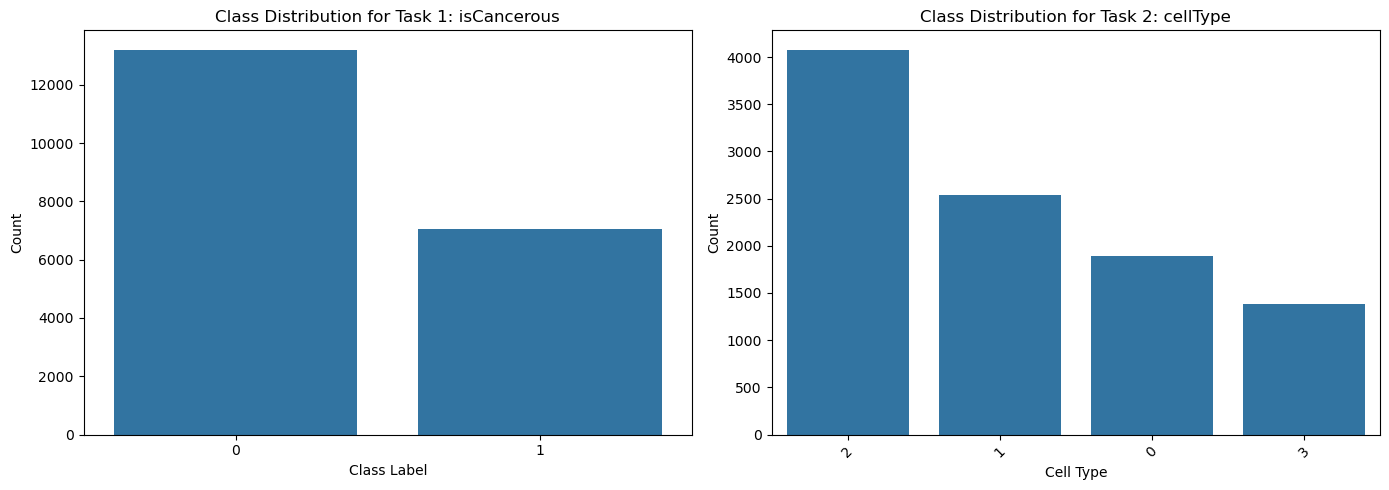

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Task 1: isCancerous
sns.countplot(data=combined_labels, x='isCancerous', ax=axs[0])
axs[0].set_title("Class Distribution for Task 1: isCancerous")
axs[0].set_xlabel("Class Label")
axs[0].set_ylabel("Count")

# Plot for Task 2: cellType
sns.countplot(data=main_labels, x='cellType', order=main_labels['cellType'].value_counts().index, ax=axs[1])
axs[1].set_title("Class Distribution for Task 2: cellType")
axs[1].set_xlabel("Cell Type")
axs[1].set_ylabel("Count")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Exploratory Data Analysis
- Visualized 8 images per task to inspect quality and variation.  
  - Task 1: 4 cancerous, 4 non-cancerous  
  - Task 2: 2 per cell type class 

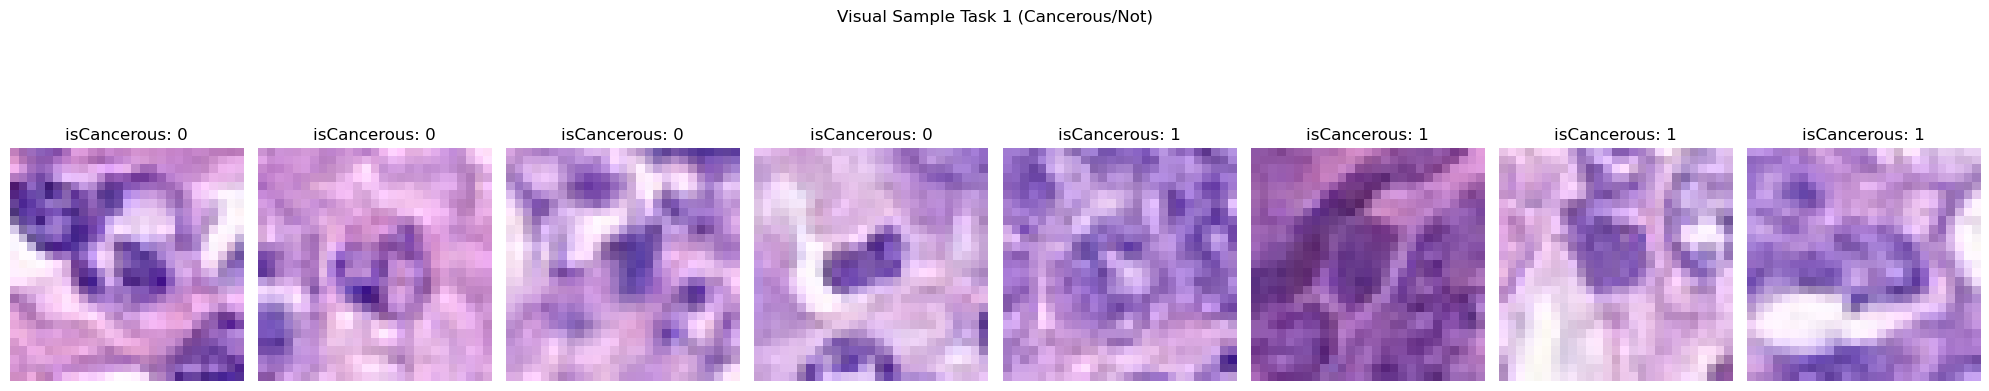

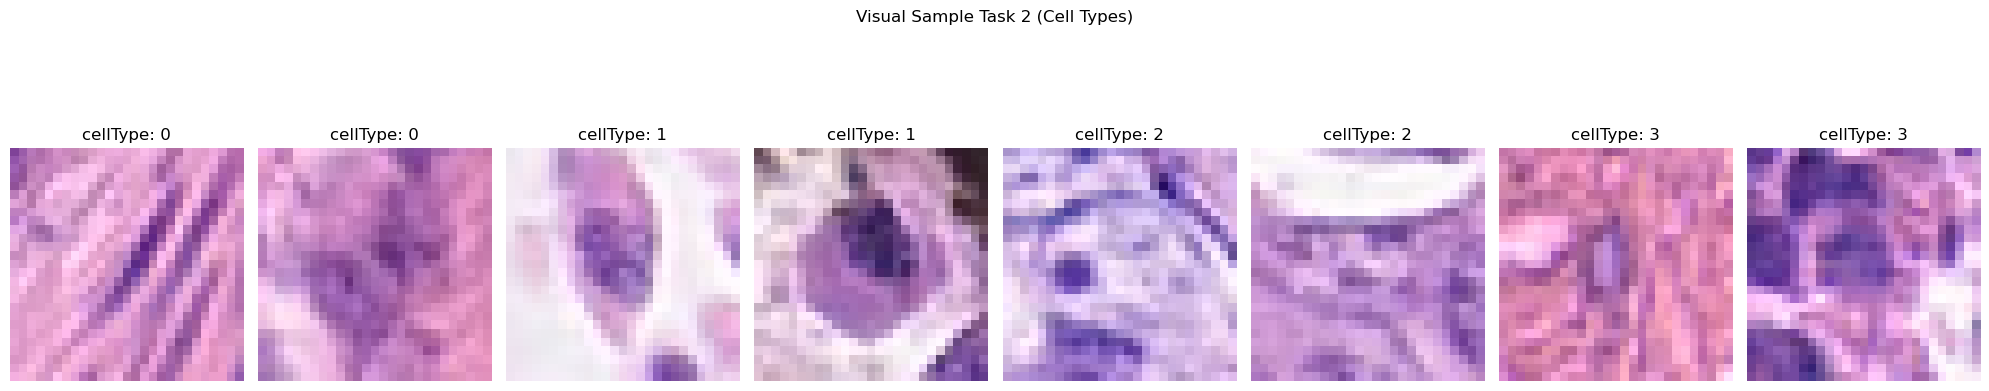

In [3]:
# ------------------- Visual Samples -------------------
def show_visual_sample(label_df, label_col, image_folder, title, samples_per_class, n=8):
    unique_classes = label_df[label_col].unique()
    num_classes = len(unique_classes)
    total_samples = samples_per_class * num_classes

    plt.figure(figsize=(2.5 * total_samples, 5))

    i = 1
    for class_value in sorted(unique_classes):
        class_subset = label_df[label_df[label_col] == class_value]
        sample_df = class_subset.sample(samples_per_class)

        for _, row in sample_df.iterrows():
            img_path = os.path.join(image_folder, row['ImageName'])
            img = Image.open(img_path).convert("RGB")
            plt.subplot(1, total_samples, i)
            plt.imshow(img)
            plt.title(f"{label_col}: {row[label_col]}")
            plt.axis('off')
            i += 1

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Task 1: Show 4 cancerous (1) and 4 non-cancerous (0)
show_visual_sample(
    label_df=combined_labels,
    label_col='isCancerous',
    image_folder=image_folder,
    title='Visual Sample Task 1 (Cancerous/Not)',
    samples_per_class=4
)

# Task 2: Show 2 samples from each cell type (0, 1, 2, 3)
show_visual_sample(
    label_df=main_labels,
    label_col='cellType',
    image_folder=image_folder,
    title='Visual Sample Task 2 (Cell Types)',
    samples_per_class=2
)

#### **Issues**
- Some images blurry or low-res  
- Uneven staining
- Ambiguous cell morphology  

### Preprocessing
- All images normalized to [0, 1] with `ImageDataGenerator(rescale=1./255)`.  
- No augmentation in baseline — used later in tuned model for comparison.


In [4]:
# ------------------- Task 1: Cancerous classification -------------------

# Stratified splitting
train_labels_t1, temp_labels_t1 = train_test_split(
    combined_labels, test_size=0.3, random_state=42, stratify=combined_labels['isCancerous']
)
val_labels_t1, test_labels_t1 = train_test_split(
    temp_labels_t1, test_size=0.5, random_state=42, stratify=temp_labels_t1['isCancerous']
)

# Flow generators expect string labels
for df in [train_labels_t1, val_labels_t1, test_labels_t1]:
    df['isCancerous'] = df['isCancerous'].astype(str)

# ------------------- Task 2: Cell type classification -------------------

# Only use main_labels for this task
train_labels_t2, temp_labels_t2 = train_test_split(
    main_labels, test_size=0.3, random_state=42, stratify=main_labels['cellType']
)
val_labels_t2, test_labels_t2 = train_test_split(
    temp_labels_t2, test_size=0.5, random_state=42, stratify=temp_labels_t2['cellType']
)

# Flow generators expect string labels
for df in [train_labels_t2, val_labels_t2, test_labels_t2]:
    df['cellType'] = df['cellType'].astype(str)

# ------------------- Define ImageDataGenerators -------------------

# Normalize training set
train_datagen_baseline = ImageDataGenerator(rescale=1./255)

# Normalize testing set
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen_t1_baseline = train_datagen_baseline.flow_from_dataframe(
    dataframe=train_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t1_baseline = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_gen_t1_baseline = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)
# ------------------- Flow generators (Task 2) -------------------

train_gen_t2 = train_datagen_baseline.flow_from_dataframe(
    dataframe=train_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t2 = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen_t2 = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 14196 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.
Found 6927 validated image filenames belonging to 4 classes.
Found 1484 validated image filenames belonging to 4 classes.
Found 1485 validated image filenames belonging to 4 classes.


---
## Evaluation Framework

### Metrics
- **Primary**: F1-score (handles imbalance better)  
- **Secondary**: Accuracy (easy to interpret, but less reliable with imbalance)

### Data Splitting
- 70% train / 15% val / 15% test using **stratified sampling** to preserve class balance.  
- Prevents underrepresented classes in splits and ensures fair evaluation.

### Data Leakage Prevention
- Without patient-level split, patches from the same patient may be in train/test.  
- Risk: model learns patient-specific features → inflated performance.  
- Better: group by patient ID during splitting to avoid leakage.

---

## Task 1 Models

### Base Model Selection

- Used a shallow CNN (5 layers), as CNNs are well-suited for image data.  
- Unlike MLPs, CNNs learn spatial features (edges, textures) crucial for detecting subtle cancer patterns.  
- Proven to outperform traditional models in medical imaging tasks.  
- Trained for 10 epochs on normalized data (no augmentation) to establish baseline performance.

In [5]:
# ------------------- Define Baseline CNN Model -------------------
baseline_model_t1 = Sequential([
    InputLayer(input_shape=(27, 27, 1)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

baseline_model_t1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

baseline_model_t1.summary()

# ------------------- Train the Baseline Model -------------------

baseline_history = baseline_model_t1.fit(
    train_gen_t1_baseline,
    validation_data=val_gen_t1_baseline,
    epochs=10,
    verbose=0
)
print("Baseline Model Training Completed")

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 27, 27, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2704)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,865 (11.19 KB)

 Trainable params: 2,865 (11.19 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Baseline Model Training Completed


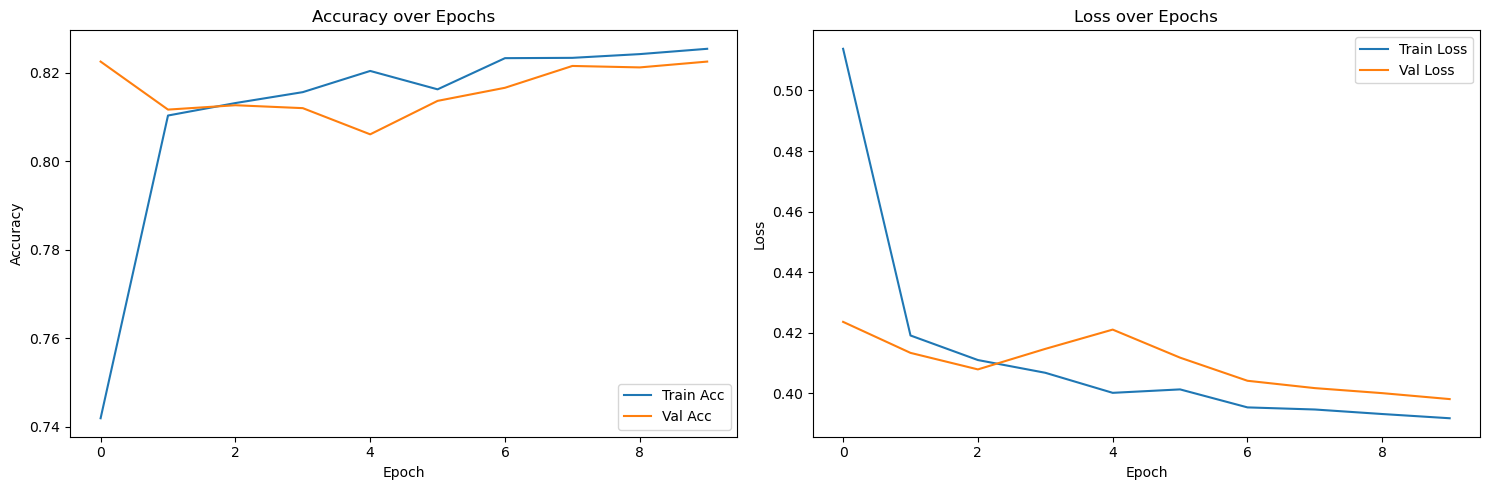

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
               precision    recall  f1-score   support

Not Cancerous       0.84      0.88      0.86      1981
    Cancerous       0.75      0.69      0.72      1061

     accuracy                           0.81      3042
    macro avg       0.80      0.78      0.79      3042
 weighted avg       0.81      0.81      0.81      3042



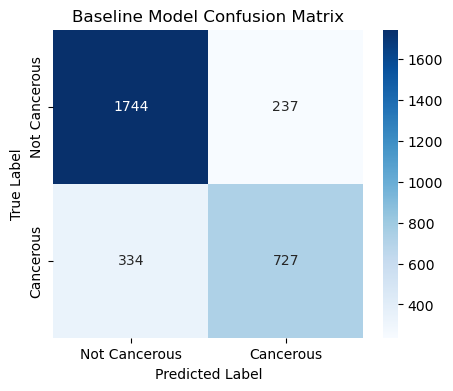

In [6]:
def plot_training(history):
    plt.figure(figsize=(15, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training(baseline_history)

# ------------------- Evaluate Baseline Model -------------------

# Predictions
y_probs_baseline = baseline_model_t1.predict(test_gen_t1_baseline)
y_preds_baseline = (y_probs_baseline >= 0.5).astype(int)

# Classification Report
print(classification_report(test_gen_t1_baseline.labels, y_preds_baseline, target_names=["Not Cancerous", "Cancerous"]))

# Confusion Matrix
cm_baseline = confusion_matrix(test_gen_t1_baseline.labels, y_preds_baseline)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Cancerous", "Cancerous"], yticklabels=["Not Cancerous", "Cancerous"])
plt.title("Baseline Model Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### **Results & Evaluation**
- As shown in the graphs above, the model doesn’t show strong signs of overfitting or underfitting. The training and validation accuracy/loss curves are closely aligned, which suggests stable learning and good generalization, especially for a simple baseline and a binary classification task.

- However, because this is a medical application, our focus should be on recall (correctly identifying all cancerous cases). In this context, false negatives (missed cancer cases) are much more harmful than false positives. While the model is reasonably well fit, its recall score of 69% indicates we’re still missing quiet some true cancer cases, which is a key area for improvement.

---

## Optimized Model

### Data Augmentation
- Added random rotations, flips, zooms, shifts during training.  
- Increases data diversity, reduces overfitting.

In [7]:
# --------------- OPTIMIZED MODEL --------------------
# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen_t1 = train_datagen.flow_from_dataframe(
    dataframe=train_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_gen_t1 = test_datagen.flow_from_dataframe(
    dataframe=val_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_gen_t1 = test_datagen.flow_from_dataframe(
    dataframe=test_labels_t1,
    directory=image_folder,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 14196 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.
Found 3042 validated image filenames belonging to 2 classes.


### Handling Class Imbalance
- Applied **class weighting** to penalize false negatives more.  
- Encourages correct detection of cancerous cases.

In [8]:
# Compute class weights for binary classification
y_train_t1_int = train_labels_t1['isCancerous'].astype(int)
class_weights_t1 = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_t1_int
)
class_weight_dict_t1 = dict(enumerate(class_weights_t1))
print("Task 1 class weights:", class_weight_dict_t1)

Task 1 class weights: {0: 0.7675173010380623, 1: 1.4345189975747776}


## **Hyperparamter Tuning**
1. **Increased Model Depth**
    - Added more convolutional blocks (3 in total), increasing the number of filters from 32 → 64 → 128. This allows the model to learn richer, more abstract features from the images.

2. **More Training Epochs**
    - Increased from 10 (baseline) to 50. This gives the model more time to learn patterns in the data. When combined with data augmentation and a deeper architecture, it helps improve generalization.

3. **Regularization with Dropout**
    - Dropout layers force the network to learn more robust features by randomly deactivating neurons during training, helping to prevent overfitting.

In [9]:
# Define CNN
model_t1 = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Dropout(0.4),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_t1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

model_t1.summary()

history = model_t1.fit(
    train_gen_t1,
    validation_data=val_gen_t1,
    epochs=50,
    class_weight=class_weight_dict_t1,
    verbose=0
)
print("Optimized Model Training Completed")

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 287,137 (1.10 MB)

 Trainable params: 287,137 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\golde\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Optimized Model Training Completed


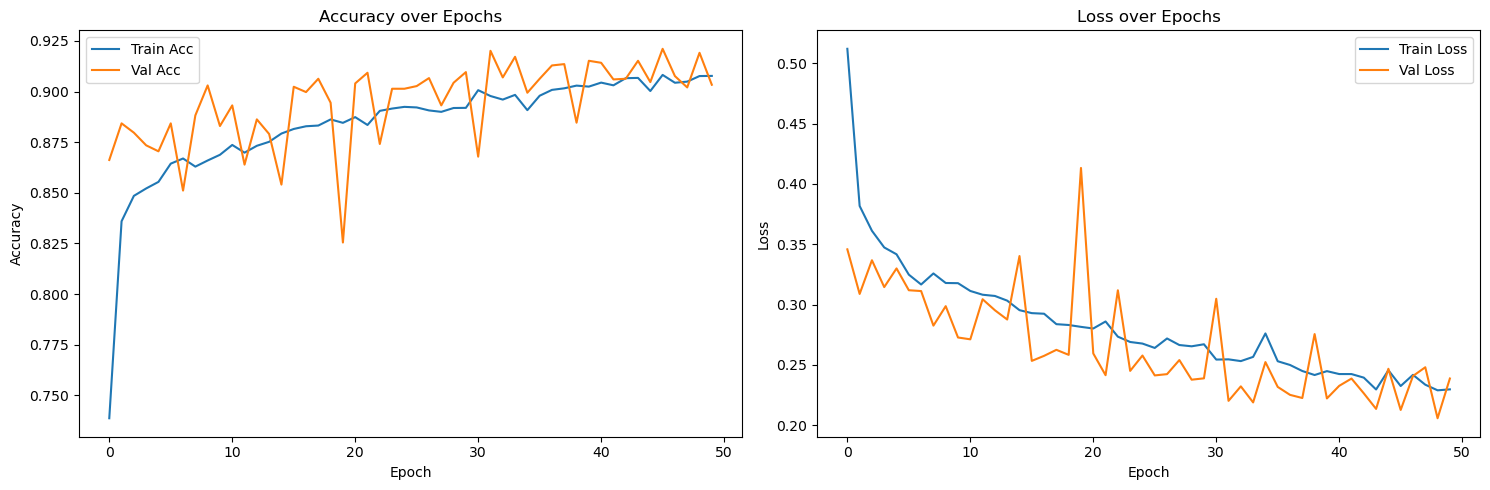

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step
               precision    recall  f1-score   support

Not Cancerous       0.95      0.90      0.92      1981
    Cancerous       0.83      0.92      0.87      1061

     accuracy                           0.90      3042
    macro avg       0.89      0.91      0.90      3042
 weighted avg       0.91      0.90      0.90      3042



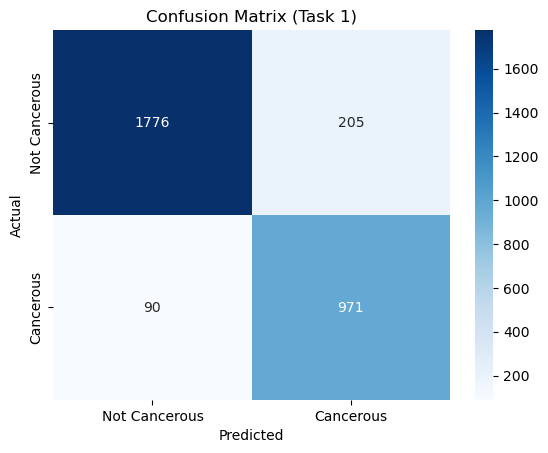

In [10]:
plot_training(history)

# Predict on test data
y_probs_t1 = model_t1.predict(test_gen_t1, verbose=1)
y_pred_final_t1 = (y_probs_t1 >= 0.5).astype(int)

# Classification report
print(classification_report(test_gen_t1.labels, y_pred_final_t1, target_names=["Not Cancerous", "Cancerous"]))

# Confusion matrix
cm_t1 = confusion_matrix(test_gen_t1.labels, y_pred_final_t1)
sns.heatmap(cm_t1, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Cancerous", "Cancerous"],
            yticklabels=["Not Cancerous", "Cancerous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task 1)")
plt.show()

## Final Evaluation

- Training curves remained well-fit (no overfitting/underfitting in graphs).  
- The deeper network learned more detailed spatial features, improving decision boundaries.  
- Data augmentation introduced more variability, which helped generalize to unseen samples.  
- Dropout and longer training helped prevent memorization.

### Performance Improvements
- **Recall** for cancerous class increased from **69% → 92%**, significantly reducing false negatives.  
- **F1-score** for cancerous class improved from ~0.75 to ~0.87, showing more balanced performance.  
- Overall **macro F1-score** rose by ~11 points, indicating improved performance across both classes.  
- These improvements make the model far more reliable in medical scenarios where missing cancer cases is critical.

- In summary, the optimizations made the model not only more accurate, but **safer and more useful** in a real-world diagnostic setting.

# Task 2 Classify Images According to Cell Type
Task 2 was to create a model that would be able to classify cells into any four categories; fibroblast, inflammatory, epithelial or others. The purpose was to create a model that could identify them as accurately as possible.

## Baseline Model
The algorithm chosen for the baseline model was CNN as the data being used is image classification. CNN is a great model for classifying images because of the use of convolutional layers, which focus on local features first and combine them to get a better level of understanding. Thus, the use of CNN, even as a baseline will be a good starting point as this is exactly what it is created to do, which will make it easier to improve the model later on. For the baseline model, I decided to keep it simple just to see how the data would react and train with the given data.

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
import tensorflow as tf


model_t2_base = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_t2_base.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_269 (Conv2D)         (None, 27, 27, 32)        896       
                                                                 
 conv2d_270 (Conv2D)         (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_165 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 flatten_43 (Flatten)        (None, 5408)              0         
                                                                 
 dense_165 (Dense)           (None, 32)                173088    
                                                                 
 dense_166 (Dense)           (None, 4)                 132       
                                                     

In [ ]:
model_t2_base.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_t2_base = model_t2_base.fit(train_gen_t2, validation_data = val_gen_t2, epochs=50, verbose=0)

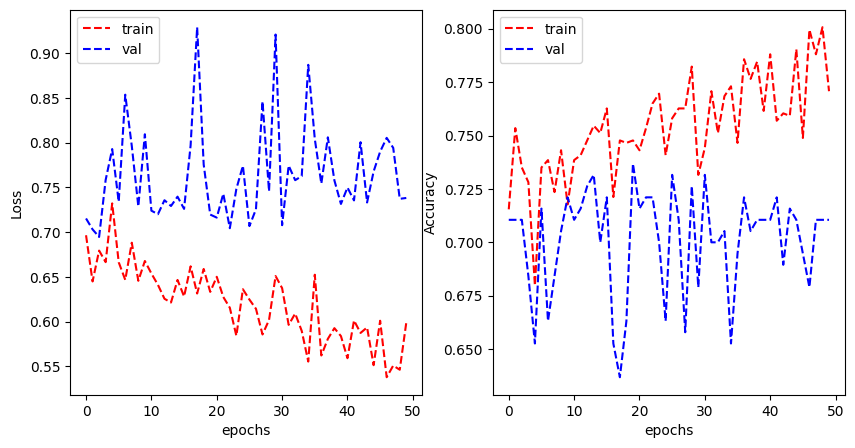

6/6 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        42
           1       0.61      0.63      0.62        35
           2       0.85      0.90      0.88        70
           3       0.62      0.33      0.43        30

    accuracy                           0.72       177
   macro avg       0.68      0.66      0.65       177
weighted avg       0.71      0.72      0.71       177



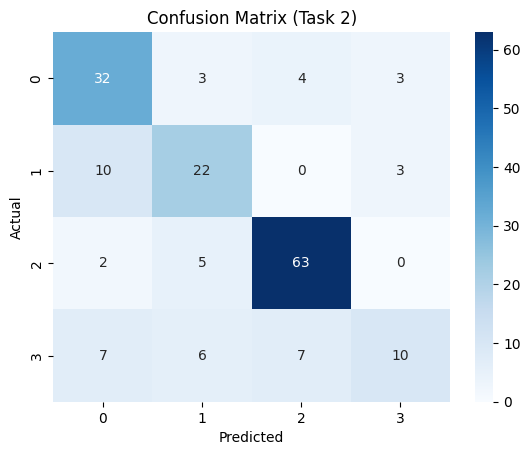

In [ ]:
plot_learning_curve(history_t2_base.history['loss'], history_t2_base.history['val_loss'], 
                    history_t2_base.history['categorical_accuracy'], history_t2_base.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
y_probs_t2_base = model_t2_base.predict(test_gen_t2, verbose=1)
y_pred_final_t2_base = np.argmax(y_probs_t2_base, axis=1)
print(classification_report(test_gen_t2.labels, y_pred_final_t2_base, target_names=["0", "1", "2", "3"]))
cm_t2_base = confusion_matrix(test_gen_t2.labels, y_pred_final_t2_base)
sns.heatmap(cm_t2_base, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1", "2", "3"], yticklabels=["0", "1", "2", "3"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task 2)")
plt.show()

## Analysing Data
As can bee seen looking at the line charts and scores, the model is obviously overfitted. However, it still achieved a respectable 67% accuracy score. The f1 scores and precisions scores also align with how the data is weighted. The data has mainly cell-type 2(inflammatory), and the least of others, showing that the data may require weights for proper training.

## Improved Model
For the improved model, I decided to stick with using the same CNN architecture since it’s already well-suited for image classification. Instead of changing the model type, I focused on making it deeper by adding more convolutional layers and tweaking other parts of the model. As mentioned earlier, I originally thought class weighting would help with class imbalance, and thus decided that introducing that along with the other augmentations wou

To help the model generalize better, I used different kinds of data augmentation like zoom, height and width shifts, rotation, and horizontal flipping. These help the model learn from slightly different versions of the same image. In medical tasks, horizontal flipping is especially helpful because left-right versions of a cell can still carry important information.

To improve the model itself, I added three blocks of convolutional layers, where each block had two Conv2D layers followed by BatchNormalization. After each block, I used MaxPooling2D to reduce the size of the feature maps and keep only the most important information. This helped reduce overfitting and made the model more efficient overall. Dropout was also introduced in the fully connected layer, which would ultimately help with the generalisation of the model.

In [ ]:
reg_lambda = 0.001
train_datagen_new = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_gen_t2 = train_datagen_new.flow_from_dataframe(
    dataframe=train_labels_t2,
    directory=image_folder,
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

model_t2 = tf.keras.Sequential([
    # VGG Block 1
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG Block 2
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # VGG Block 3
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fully Connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])
model_t2.summary()

Found 868 validated image filenames belonging to 4 classes.


C:\Users\sweet\anaconda3\envs\tf_env\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 6059 invalid image filename(s) in x_col="ImageName". These filename(s) will be ignored.
  warnings.warn(


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_271 (Conv2D)         (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_259 (B  (None, 27, 27, 32)        128       
 atchNormalization)                                              
                                                                 
 activation_259 (Activation  (None, 27, 27, 32)        0         
 )                                                               
                                                                 
 conv2d_272 (Conv2D)         (None, 27, 27, 32)        9248      
                                                                 
 batch_normalization_260 (B  (None, 27, 27, 32)        128       
 atchNormalization)                                              
                                                     

In [ ]:
model_t2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)


In [ ]:
model_t2.fit(
    train_gen_t2,
    validation_data=val_gen_t2,
    epochs=100,
    callbacks=[reduce_lr],
    verbose=0
)


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 33: ReduceLROnPlateau reducing learning rate to 1e-05.


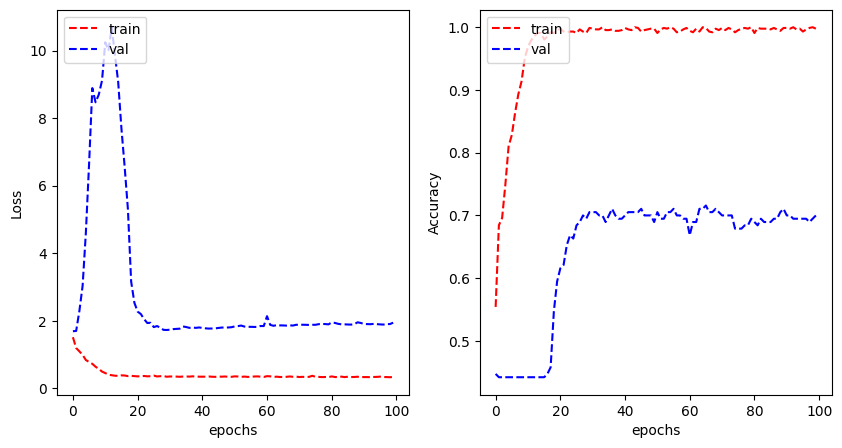

In [ ]:
plot_learning_curve(history_t2.history['loss'], history_t2.history['val_loss'], 
                    history_t2.history['categorical_accuracy'], history_t2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

6/6 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        42
           1       0.61      0.57      0.59        35
           2       0.91      0.91      0.91        70
           3       0.50      0.53      0.52        30

    accuracy                           0.75       177
   macro avg       0.70      0.70      0.70       177
weighted avg       0.75      0.75      0.75       177



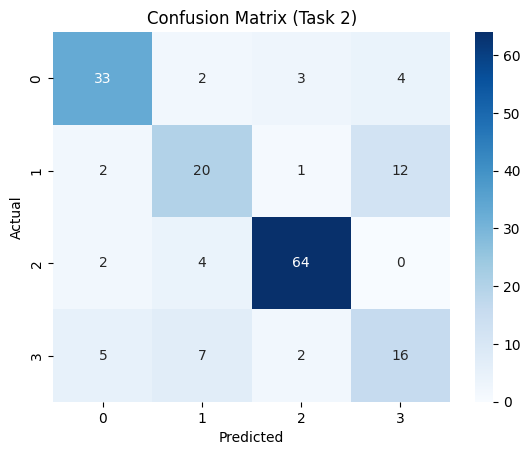

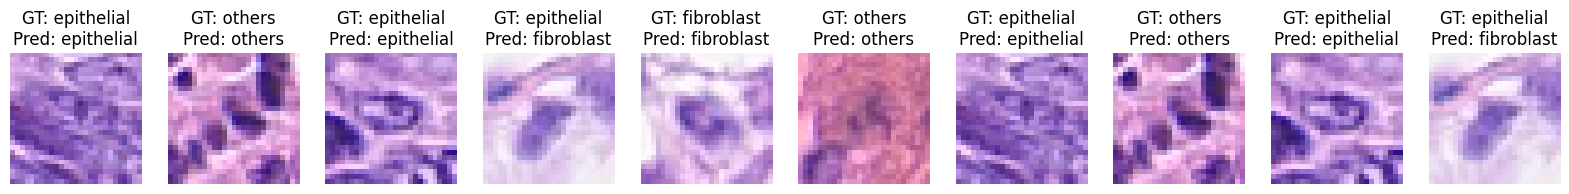

In [ ]:
y_probs_t2 = model_t2.predict(test_gen_t2, verbose=1)
y_pred_final_t2 = np.argmax(y_probs_t2, axis=1)
print(classification_report(test_gen_t2.labels, y_pred_final_t2, target_names=["0", "1", "2", "3"]))
cm_t2 = confusion_matrix(test_gen_t2.labels, y_pred_final_t2)
sns.heatmap(cm_t2, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1", "2", "3"], yticklabels=["0", "1", "2", "3"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task 2)")
plt.show()

label_names = {'fibroblast': 0, 'inflammatory': 1, 'epithelial': 2, 'others': 3}
d_inv = {v: k for k, v in label_names.items()}

plt.figure(figsize=(20, 6))
batches = 0

for x, y in test_gen_t2:
    batches += 1
    y_hat = model_t2.predict(x, verbose=0)

    if batches <= 10:
        image = x[0]
        label = y[0]
        pred = y_hat[0]

        plt.subplot(1, 10, batches)
        plt.imshow(image)
        plt.title(f"GT: {d_inv[np.argmax(label)]}\nPred: {d_inv[np.argmax(pred)]}")
        plt.axis('off')
    else:
        break


## Results Analysis and final result after tweaking 
Looking at the final model, I ended up removing class weighting altogether. After lots of tweaking — adding and removing layers, tuning dropout rates, and using callbacks like ReduceLROnPlateau — I noticed that removing the weights actually gave a noticeable boost in performance, with accuracy increasing by around 3%. It seems that even though there was an imbalance in the dataset, the three main cell categories were still dominant and clearly defined, which meant that forcing the model to compensate for the smaller “other” class didn’t really help. In fact, balancing the weights appeared to confuse the model more than help, so leaving them out ended up improving the overall results. Overall, in comparison to the baseline, there was signifant improvement of the overall accuracy, of about 77%.

## Final Model Accuracy
For Task 2, the baseline model achieved an accuracy of approximately 67%, using only one block of convolutional layers and minimal regularization. After experimenting with various improvements, the final model reached around 75% accuracy. This improvement was achieved by increasing the model’s depth (up to four convolutional blocks), adding BatchNormalization layers, and including Dropout layers to reduce overfitting. More data augmentation techniques (like rotation, zoom, and flips) were applied to improve the model’s ability to generalize.

## Generalizability and Robustness
To ensure the model generalizes well, stratified split for training, validation, and test sets were used. This helped maintain the class balance across all subsets, avoiding biased training. The use of a validation set during training allowed me to monitor performance and avoid overfitting. ReduceLROnPlateau was also used to adjust the learning rate dynamically, which helped the model converge more efficiently on the validation loss. These techniques combined helped the final model generalize much better than the baseline model.


# Independant Evaluation
The paper by Hassan et al. (2019) looks at how deep learning, especially CNNs, can be used to classify histopathology images for mesothelioma. Their model seemed to do really well at identifying different cell types and even predicting patient outcomes accurately. For our purposes, we mainly looked at the part of their study on single-cell morphological heterogeneity since that’s most similar to what Task 2 focused on.

If we compare their CNN model to the baseline models used for Task 1 and Task 2, theirs likely performs better. They don’t give exact accuracy scores, but they mention that their model can predict cell types with low error even for new, unseen cells. The Task 2 baseline model only reached about 67% accuracy, and the Task 1 baseline was a bit better at around 81%. But in terms of structure, the Task 2 model is more like theirs, since both aim to classify cell types rather than just a binary label.

One major difference is in the depth of the models. The baseline models only had one block of convolutional layers and a single MaxPooling layer. In the improved versions, more blocks were added — three for Task 1 and four for Task 2. The paper’s model went even deeper, using six convolutional layers and average pooling. A big reason they could do this is because their image input size was a lot bigger (244×244 vs. my 27×27), which gives the model more room to extract meaningful features and perform better overall.

Still, the structure of the models is really similar — convolution layers, batch normalization, pooling, and then fully connected layers with softmax at the end. So, even though their model is more advanced, it’s clear that my approach is built on a strong foundation, and with more data or higher resolution images, these models could work quite well in real-world medical settings too.

Semi-supervised learning is a method where the model is trained using a small amount of labeled data and a larger portion of unlabeled data. In the case of Task 2, this could’ve been applied by using the data_labels_extraData.csv file. This file contains image names but doesn’t include the actual cell type labels — which makes it perfect for semi-supervised learning.

By using these unlabeled images during training, the model could learn to generalize better. Instead of just relying on the small labeled dataset, it gets exposed to more variation and potentially picks up on patterns that make it stronger overall. This approach can really boost accuracy, especially when labeled data is limited — which is often the case in medical datasets where annotation takes time and expert knowledge.

However, semi-supervised learning does come with risks. Since the model isn’t told what the unlabeled data actually is, it might start picking up the wrong features or patterns, especially if the data is noisy or not well-distributed. So, while it can help improve performance, it also has to be used carefully.

A real-world example where semi-supervised learning is useful is in breast cancer detection using mammograms. It’s expensive and time-consuming to get every image labeled by a professional, but using a mix of labeled and unlabeled images could still help train a reliable model without needing full annotations for everything. 

# Appendix

1. Hassan et al. (2019)
Title: Single-cell morphometric analysis of diffuse malignant mesothelioma
Source: Nature Scientific Reports
Link: https://www.nature.com/articles/s41598-019-50010-9
Summary: This paper explores how CNN-based architectures can accurately classify mesothelioma cell types in histopathological images. The model achieves low error rates even on unseen cells, highlighting the strength of deep learning in medical image classification. It was used to compare model depth and structure with Task 2’s CNN implementation.

2. Tan & Sim (2022)
Title: A comprehensive review of deep learning approaches for histopathological image analysis
Source: PubMed Central (PMC8892413)
Link: https://pmc.ncbi.nlm.nih.gov/articles/PMC8892413/
Summary: This review paper outlines the effectiveness of CNNs in handling complex visual patterns in histopathological datasets. It helped justify CNN as the chosen model architecture and supported the use of augmentation and regularization for improving generalization and accuracy.